In [1]:
import os

import numpy as np
import importlib
import gymnasium as gym
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import patches
import matplotlib.animation as manimation

import gym_env
import utils
from utils import gen_nhb_exp_SR
from models import LinearRL_NHB #, SR_NHB
from utils_render import plot_nhb_decisions
from utils import policy_reval, woodbury

In [2]:
# Set the random seed for NumPy
seed = 42
np.random.seed(42)

# Save dir
save_dir = os.path.join('..', 'figures/')

In [3]:
# For plotting
prob_locs = [1, 2]
colors = [3, 2]

In [4]:
# Hyperparameters
# lambd = 10
# alpha = 0.25
# beta = 0.9
# num_steps = 250
# num_iterations = 400

lambd = 10
alpha = 0.15
beta = 1.0
num_steps = 250
num_iterations = 400

In [5]:
class SR_NHB:
    def __init__(self, alpha=0.1, beta=1, gamma=0.904, num_steps=25000, policy="random", exp_type="policy_reval"):
        # Hard code start and end locations as well as size
        self.start_loc = 0
        self.target_locs = [3,4,5]
        self.size = 6
        self.agent_loc = self.start_loc
        self.exp_type = exp_type

        # Construct the transition probability matrix and envstep functions
        self.T = self.construct_T()
        self.envstep = gen_nhb_exp_SR()

        # Get terminal states
        self.terminals = np.diag(self.T) == 1

        # Set reward
        self.reward_nt = 1
        self.r = np.full(len(self.T), self.reward_nt)
        # Reward of terminal states depends on if we are replicating reward revaluation or policy revaluation
        if self.exp_type == "policy_reval":
            self.r_term_1 = [0, 15, 30]
            self.r_term_2 = [45, 15, 30]
        elif self.exp_type == "reward_reval":
            self.r_term_1 = [15, 0, 30]
            self.r_term_2 = [45, 0, 30]
        else:
            print("Incorrect experiment type (exp_type)")
            return(0)
        self.r[self.terminals] = self.r_term_1

        # Params
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.num_steps = num_steps
        self.policy = policy

        # Model
        self.SR = np.eye(self.size)
        self.V = np.zeros(self.size)
        self.one_hot = np.eye(self.size)

    def construct_T(self):
        """
        Manually construct a T that is biased by a decision policy
        """
        T = np.zeros((6, 6))
        T[0,1] = 0.5
        T[0,2] = 0.5
        T[1,3] = 0.5
        T[1,4] = 0.5
        T[2,4] = 0.5
        T[2,5] = 0.5
        T[3:6, 3:6] = np.eye(3)

        return T
    
    def update_exp(self):
        """
        Update the terminal state values or transition matrix (experiment dependent)
        """
        if self.exp_type in ["reward_reval", "policy_reval"]:
            self.r[self.terminals] = self.r_term_2

    def update_V(self):
        self.V = self.SR @ self.r

    def get_successor_states(self, state):
        """
        Manually define the successor states based on which state we are in
        """
        return np.where(self.T[state, :] != 0)[0]

    def select_action(self, state):
        """
        Action selection based on our policy
        Options are: [random, softmax, egreedy, test]
        """
        if self.policy == "random":
            successor_states = self.get_successor_states(state)
            return np.random.choice([0,1])

        elif self.policy == "softmax":
            successor_states = self.get_successor_states(state)
            action_probs = np.full(2, 0.0)   # We can hardcode this because every state has 2 actions

            V = self.V[successor_states]
            exp_V = np.exp(V / self.beta)
            action_probs = exp_V / exp_V.sum()

            action = np.random.choice([0,1], p=action_probs)

            return action

    def learn(self, seed=None):
        """
        Agent explores the maze according to its decision policy and and updates its DR as it goes
        """
        if seed is not None:
            np.random.seed(seed=seed)

        # Iterate through number of steps
        for i in range(self.num_steps):
            # Current state
            state = self.agent_loc
            action = self.select_action(state)
            # print(state, action)

            # Take action
            next_state, done = self.envstep[state, action]

            # Update default representation
            # target = self.one_hot[state] + self.gamma * self.SR[next_state]
            # self.SR[state] = (1 - self.alpha) * self.SR[state] + self.alpha * target
            self.SR[state] = (1-self.alpha)* self.SR[state] + self.alpha * ( self.one_hot[state] + self.gamma * self.SR[next_state]  )

            # Update Values
            self.update_V()

            if done:
                self.agent_loc = self.start_loc
                continue

            # Update state
            state = next_state
            self.agent_loc = state

# Policy Revaluation

## Run Simulations

### Complete Model

In [6]:
choices_complete = {"train":np.array([0,0]), "test":np.array([0,0])}
for i in range(num_iterations):
    # Define agent
    agent_complete =  LinearRL_NHB(_lambda=lambd, alpha=alpha, beta=beta, num_steps=num_steps, policy="softmax", imp_samp=True, exp_type="policy_reval")
    # Get optimal DR and update V and Z Values
    D_inv = agent_complete.get_D_inv()
    agent_complete.DR = D_inv
    agent_complete.update_Z()
    agent_complete.update_V()
    dec_train = np.argmax([agent_complete.V[1], agent_complete.V[2]])
    choices_complete["train"][dec_train] += 1

    # Update terminal state values
    agent_complete.update_exp()
    V_new, Z_new = policy_reval(agent_complete)
    dec_test = np.argmax([V_new[1], V_new[2]])
    choices_complete["test"][dec_test] += 1

### TD Models

In [7]:
choices_with = {"train":np.array([0,0]), "test":np.array([0,0])}
choices_without = {"train":np.array([0,0]), "test":np.array([0,0])}
choices_sr = {"train":np.array([0,0]), "test":np.array([0,0])}

for i in range(num_iterations):
    # Define agents
    agent_with_imp = LinearRL_NHB(_lambda=lambd, alpha=alpha, beta=beta, num_steps=num_steps, policy="softmax", imp_samp=True, exp_type="policy_reval")
    agent_without_imp = LinearRL_NHB(_lambda=lambd, alpha=alpha, beta=beta, num_steps=num_steps, policy="softmax", imp_samp=False, exp_type="policy_reval")
    agent_SR = SR_NHB(alpha=alpha, beta=10.0, num_steps=num_steps, policy="softmax", exp_type="policy_reval")

    # Have the agents learn the environment
    agent_with_imp.learn(seed=i)
    agent_without_imp.learn(seed=i)
    agent_SR.learn(seed=i)
    
    ## SR
    # Original training policy
    dec_train = np.argmax([agent_SR.V[1], agent_SR.V[2]])
    choices_sr["train"][dec_train] += 1
    # Policy revaluation
    agent_SR.update_exp()
    agent_SR.update_V()
    # New policy
    dec_test = np.argmax([agent_SR.V[1], agent_SR.V[2]])
    choices_sr["test"][dec_test] += 1


    ## With importance sampling
    # Original training policy
    dec_train = np.argmax([agent_with_imp.V[1], agent_with_imp.V[2]])
    choices_with["train"][dec_train] += 1
    # Policy revaluation
    agent_with_imp.update_exp()
    V_new, Z_new = policy_reval(agent_with_imp)
    # New policy
    dec_test = np.argmax([V_new[1], V_new[2]])
    choices_with["test"][dec_test] += 1

    ## Without importance sampling
    # Original training policy
    dec_train = np.argmax([agent_without_imp.V[1], agent_without_imp.V[2]])
    choices_without["train"][dec_train] += 1
    # Policy revaluation
    agent_without_imp.update_exp()
    V_new, Z_new = policy_reval(agent_without_imp)
    # New policy
    dec_test = np.argmax([V_new[1], V_new[2]])
    choices_without["test"][dec_test] += 1


In [8]:
print(choices_with["train"])
print(f"selected state 1: {choices_with['test'][0]/num_iterations}\n")
print(choices_without)
print(f"selected state 1: {choices_without['test'][0]/num_iterations}")

[  0 400]
selected state 1: 0.755

{'train': array([  1, 399]), 'test': array([182, 218])}
selected state 1: 0.455


## Action Selection Probs

### Complete

In [9]:
prob_policy_complete = choices_complete["test"] / num_iterations
p_comp = choices_complete["test"][1] / num_iterations
std_policy_complete = np.sqrt((p_comp * (1 - p_comp)) / num_iterations)

### SR

In [10]:
prob_policy_sr = choices_sr["test"] / num_iterations
p_sr = choices_sr["test"][1] / num_iterations
std_policy_sr = np.sqrt((p_sr * (1 - p_sr)) / num_iterations)

### With Importance Sampling

In [11]:
# save_path = save_dir + 'policy_reval_nhb_with_is.png'

# prob_train = choices_with["train"] / num_iterations
# prob_test = choices_with["test"] / num_iterations
prob_policy_with = choices_with["test"] / num_iterations

# p_train = choices_with["train"][1] / num_iterations
p_test = choices_with["test"][1] / num_iterations
# std_train = np.sqrt((p_train * (1 - p_train)) / num_iterations)
# std_test = np.sqrt((p_test * (1 - p_test)) / num_iterations)
std_policy_with = np.sqrt((p_test * (1 - p_test)) / num_iterations)

# plot_decision_prob(probs_train=prob_train, probs_test=prob_test, colors=colors, std=[std_train, std_test], save_path=None, title=None)

### Without Importance Sampling

In [12]:
# save_path = save_dir + 'policy_reval_nhb_without_is.png'

# prob_train = choices_without["train"] / num_iterations
# prob_test = choices_without["test"] / num_iterations
prob_policy_without = choices_without["test"] / num_iterations

# p_train = choices_without["train"][1] / num_iterations
p_test = choices_without["test"][1] / num_iterations
# std_train = np.sqrt((p_train * (1 - p_train)) / num_iterations)
# std_test = np.sqrt((p_test * (1 - p_test)) / num_iterations)
std_policy_without = np.sqrt((p_test * (1 - p_test)) / num_iterations)

# plot_decision_prob(probs_train=prob_train, probs_test=prob_test, colors=colors, std=[std_train, std_test], save_path=None, title=None)

# Reward Revaluation

## Run Simulations

### Complete Model

In [13]:
choices_complete = {"train":np.array([0,0]), "test":np.array([0,0])}
for i in range(num_iterations):
    # Define agent
    agent_complete =  LinearRL_NHB(_lambda=lambd, alpha=alpha, beta=beta, num_steps=num_steps, policy="softmax", imp_samp=True, exp_type="reward_reval")
    # Get optimal DR and update V and Z Values
    D_inv = agent_complete.get_D_inv()
    agent_complete.DR = D_inv
    agent_complete.update_Z()
    agent_complete.update_V()
    dec_train = np.argmax([agent_complete.V[1], agent_complete.V[2]])
    choices_complete["train"][dec_train] += 1

    # Update terminal state values
    agent_complete.update_exp()
    V_new, Z_new = policy_reval(agent_complete)
    dec_test = np.argmax([V_new[1], V_new[2]])
    choices_complete["test"][dec_test] += 1

### TD Models

In [14]:
choices_with = {"train":np.array([0,0]), "test":np.array([0,0])}
choices_without = {"train":np.array([0,0]), "test":np.array([0,0])}
choices_sr = {"train":np.array([0,0]), "test":np.array([0,0])}

for i in range(num_iterations):
    # Define agents
    agent_with_imp = LinearRL_NHB(_lambda=lambd, alpha=alpha, beta=beta, num_steps=num_steps, policy="softmax", imp_samp=True, exp_type="reward_reval")
    agent_without_imp = LinearRL_NHB(_lambda=lambd, alpha=alpha, beta=beta, num_steps=num_steps, policy="softmax", imp_samp=False, exp_type="reward_reval")
    agent_SR = SR_NHB(alpha=alpha, beta=10.0, num_steps=num_steps, policy="softmax", exp_type="reward_reval")

    # Have the agents learn the environment
    agent_with_imp.learn(seed=i)
    agent_without_imp.learn(seed=i)
    agent_SR.learn(seed=i)

    ## SR
    # Original training policy
    dec_train = np.argmax([agent_SR.V[1], agent_SR.V[2]])
    choices_sr["train"][dec_train] += 1
    # Policy revaluation
    agent_SR.update_exp()
    agent_SR.update_V()
    # New policy
    dec_test = np.argmax([agent_SR.V[1], agent_SR.V[2]])
    choices_sr["test"][dec_test] += 1
    
    ## With importance sampling
    # Original training policy
    dec_train = np.argmax([agent_with_imp.V[1], agent_with_imp.V[2]])
    choices_with["train"][dec_train] += 1
    # Policy revaluation
    agent_with_imp.update_exp()
    V_new, Z_new = policy_reval(agent_with_imp)
    # New policy
    dec_test = np.argmax([V_new[1], V_new[2]])
    choices_with["test"][dec_test] += 1

    ## Without importance sampling
    # Original training policy
    dec_train = np.argmax([agent_without_imp.V[1], agent_without_imp.V[2]])
    choices_without["train"][dec_train] += 1
    # Policy revaluation
    agent_without_imp.update_exp()
    V_new, Z_new = policy_reval(agent_without_imp)
    # New policy
    dec_test = np.argmax([V_new[1], V_new[2]])
    choices_without["test"][dec_test] += 1

In [15]:
print(choices_with["train"])
print(f"selected state 1: {choices_with['test'][0]/num_iterations}\n")
print(choices_without)
print(f"selected state 1: {choices_without['test'][0]/num_iterations}")

[  0 400]
selected state 1: 0.9025

{'train': array([  0, 400]), 'test': array([308,  92])}
selected state 1: 0.77


## Action Selection Probs

### Complete

In [16]:
prob_reward_complete = choices_complete["test"] / num_iterations
p_comp = choices_complete["test"][1] / num_iterations
std_reward_complete = np.sqrt((p_comp * (1 - p_comp)) / num_iterations)

### SR

In [17]:
prob_reward_sr = choices_sr["test"] / num_iterations
p_sr = choices_sr["test"][1] / num_iterations
std_reward_sr = np.sqrt((p_sr * (1 - p_sr)) / num_iterations)

### With Importance Sampling

In [18]:
# save_path = save_dir + 'reward_reval_nhb_with_is.png'

# prob_train = choices_with["train"] / num_iterations
# prob_test = choices_with["test"] / num_iterations
prob_reward_with = choices_with["test"] / num_iterations

# p_train = choices_with["train"][1] / num_iterations
p_test = choices_with["test"][1] / num_iterations
# std_train = np.sqrt((p_train * (1 - p_train)) / num_iterations)
# std_test = np.sqrt((p_test * (1 - p_test)) / num_iterations)
std_reward_with = np.sqrt((p_test * (1 - p_test)) / num_iterations)

# plot_decision_prob(probs_train=prob_train, probs_test=prob_test, colors=colors, std=[std_train, std_test], save_path=None, title=None)

### Without Importance Sampling

In [19]:
# save_path = save_dir + 'reward_reval_nhb_without_is.png'

# prob_train = choices_without["train"] / num_iterations
# prob_test = choices_without["test"] / num_iterations
prob_reward_without = choices_without["test"] / num_iterations

# p_train = choices_without["train"][1] / num_iterations
p_test = choices_without["test"][1] / num_iterations
# std_train = np.sqrt((p_train * (1 - p_train)) / num_iterations)
# std_test = np.sqrt((p_test * (1 - p_test)) / num_iterations)
std_reward_without = np.sqrt((p_test * (1 - p_test)) / num_iterations)

# plot_decision_prob(probs_train=prob_train, probs_test=prob_test, colors=colors, std=[std_train, std_test], save_path=None, title=None)

# Transition Revaluation

## Run Simulations

In [20]:
choices_with = {"train":np.array([0,0]), "test":np.array([0,0])}
choices_without = {"train":np.array([0,0]), "test":np.array([0,0])}

for i in range(num_iterations):
    # Define agents
    agent_with_imp = LinearRL_NHB(_lambda=lambd, alpha=alpha, beta=beta, num_steps=num_steps, policy="softmax", imp_samp=True, exp_type="trans_reval")
    agent_without_imp = LinearRL_NHB(_lambda=lambd, alpha=alpha, beta=beta, num_steps=num_steps, policy="softmax", imp_samp=False, exp_type="trans_reval")

    # Have the agents learn the environment
    agent_with_imp.learn(seed=i)
    agent_without_imp.learn(seed=i)

    ## With importance sampling
    # Original training policy
    dec_train = np.argmax([agent_with_imp.V[1], agent_with_imp.V[2]])
    choices_with["train"][dec_train] += 1

    # Transition revaluation
    T_new = agent_with_imp.construct_T_new()
    D_new = woodbury(agent=agent_with_imp, T=T_new, inv=False)
    agent_with_imp.DR = D_new
    agent_with_imp.update_Z()
    agent_with_imp.update_V()
    V_new = agent_with_imp.V

    # New policy
    dec_test = np.argmax([V_new[1], V_new[2]])
    choices_with["test"][dec_test] += 1

    ## Without importance sampling
    # Original training task
    dec_train = np.argmax([agent_without_imp.V[1], agent_without_imp.V[2]])
    choices_without["train"][dec_train] += 1

    # Transition revaluation
    T_new = agent_without_imp.construct_T_new()
    D_new = woodbury(agent=agent_without_imp, T=T_new, inv=False)
    agent_without_imp.DR = D_new
    agent_without_imp.update_Z()
    agent_without_imp.update_V()
    V_new = agent_without_imp.V

    # New policy
    dec_test = np.argmax([V_new[1], V_new[2]])
    choices_without["test"][dec_test] += 1

/Users/abizzle/Research/LinearRL-TD/src/models.py:350: RuntimeWarning: invalid value encountered in log
  self.V = np.round(np.log(self.Z), 2)


In [21]:
print(choices_with["train"])
print(f"selected state 1: {choices_with['test'][0]/num_iterations}\n")
print(choices_without)
print(f"selected state 1: {choices_without['test'][0]/num_iterations}")

[  0 400]
selected state 1: 0.7625

{'train': array([  0, 400]), 'test': array([110, 290])}
selected state 1: 0.275


## Plots

### With Importance Sampling

In [22]:
# save_path = save_dir + 'transition_reval_nhb_with_is.png'

# prob_train = choices_with["train"] / num_iterations
# prob_test = choices_with["test"] / num_iterations
prob_transition_with = choices_with["test"] / num_iterations

# p_train = choices_with["train"][1] / num_iterations
p_test = choices_with["test"][1] / num_iterations
# std_train = np.sqrt((p_train * (1 - p_train)) / num_iterations)
# std_test = np.sqrt((p_test * (1 - p_test)) / num_iterations)
std_transition_with = np.sqrt((p_test * (1 - p_test)) / num_iterations)

# plot_decision_prob(probs_train=prob_train, probs_test=prob_test, colors=colors, std=[std_train, std_test], save_path=None, title=None)

### Without Importance Sampling

In [23]:
# save_path = save_dir + 'transition_reval_nhb_without_is.png'

# prob_train = choices_without["train"] / num_iterations
# prob_test = choices_without["test"] / num_iterations
prob_transition_without = choices_without["test"] / num_iterations

# p_train = choices_without["train"][1] / num_iterations
p_test = choices_without["test"][1] / num_iterations
# std_train = np.sqrt((p_train * (1 - p_train)) / num_iterations)
# std_test = np.sqrt((p_test * (1 - p_test)) / num_iterations)
std_transition_without = np.sqrt((p_test * (1 - p_test)) / num_iterations)

# plot_decision_prob(probs_train=prob_train, probs_test=prob_test, colors=colors, std=[std_train, std_test], save_path=None, title=None)

# Plot Simulation Results

## With Importance Sampling

In [24]:
# save_path = save_dir + "nhb_simulations_with.png"
save_path = None

# plot_nhb_decisions(
#     probs_reward=prob_reward_with,
#     probs_policy=prob_policy_with,
#     probs_transition=prob_transition_with,
#     colors=colors,
#     leg_loc='upper right',
#     save_path=save_path,
#     title='With Importance Sampling',
#     std=[std_reward_with, std_policy_with, std_transition_with]
# )

## Without Importance Sampling

In [25]:
# save_path = save_dir + "nhb_simulations_without.png"
save_path = None

# plot_nhb_decisions(
#     probs_reward=prob_reward_without,
#     probs_policy=prob_policy_without,
#     probs_transition=prob_transition_without,
#     colors=colors,
#     leg_loc='upper right',
#     save_path=save_path,
#     title='Without Importance Sampling',
#     std=[std_reward_without, std_policy_without, std_transition_without]
# )

# Plot NHB values against ours

In [48]:
def create_bar_plot(means, colors, ylabel, xlabels, std=None, title=None, save_path=None):
    color_palette = sns.color_palette("colorblind")
    color_list = []
    for color in colors:
        color_list.append(color_palette[color])

    # Set the style and font
    plt.rcParams['font.family'] = 'serif'
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(6, 7))
    x = np.arange(len(means)) * 0.25
    
    # Plot the bars with black edge color
    bars = ax.bar(x, means, color=color_list, edgecolor='black', linewidth=1, width=0.15)
    
    # Add error bars if std is provided
    if std is not None:
        ax.errorbar(x, means, yerr=std, fmt='none', color='black', capsize=0)
    
    # Customize the plot
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_title(title, fontsize=20) if title else None
    ax.set_xticks(x)
    ax.set_xticklabels(xlabels, rotation=0, ha='center', fontsize=18)
    
    # Set y-axis limits and ticks
    ax.set_ylim(0, 1.1)
    ax.set_yticks(np.arange(0, 1.01, 0.2))
    
    # Add black border to all spines
    for spine in ['left', 'right', 'bottom', 'top']:
        ax.spines[spine].set_color('black')
        ax.spines[spine].set_linewidth(1)
    
    # Remove grid
    ax.grid(False)
    
    # Set background color to white
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')
    
    # Adjust layout
    plt.tight_layout()
    
    # Save the plot if a save path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    # Show the plot
    plt.show()

## NHB reconstruction

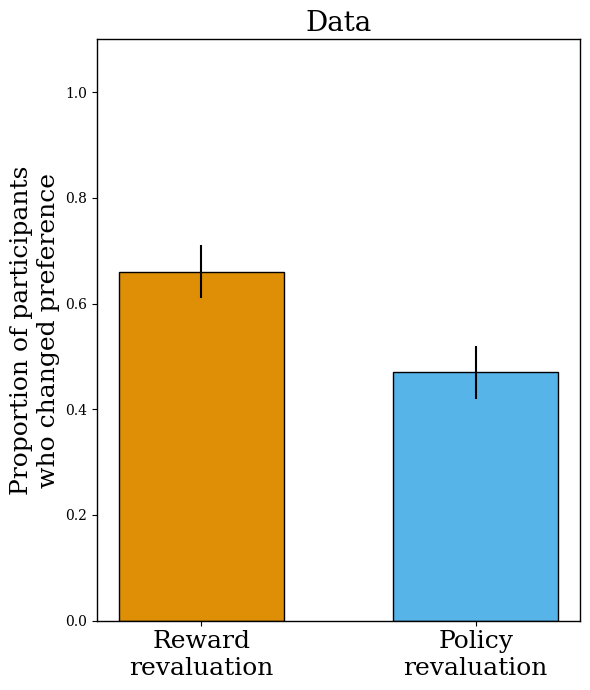

In [49]:
# save_path = save_dir + "NHB_data.png"
save_path = None
nhb_means = [0.66, 0.47]
nhb_stds = [0.05, 0.05]
xlabels = ['Reward\nrevaluation', 'Policy\nrevaluation']
colors = [1, 9]
ylabel = 'Proportion of participants\nwho changed preference'

# Call the function
create_bar_plot(nhb_means, colors, ylabel, xlabels, std=nhb_stds, save_path=save_path, title="Data")

## With Importance Sampling

In [50]:
std_reward_with

0.014831870246196196

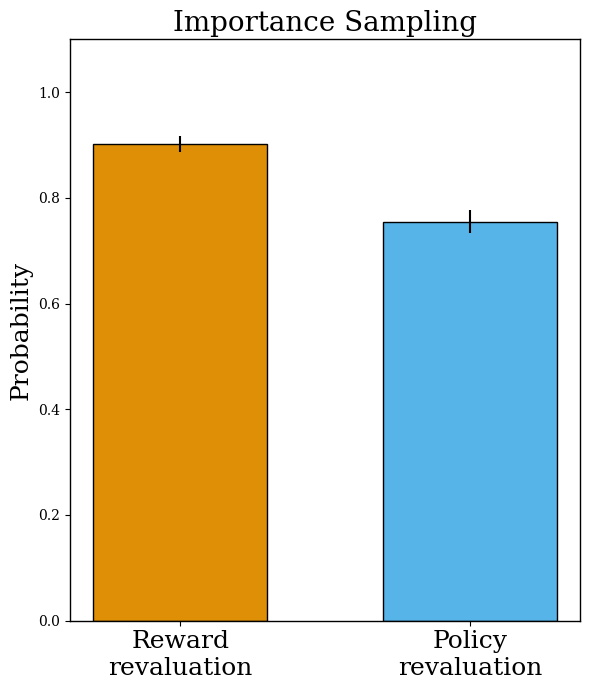

In [54]:
# save_path = save_dir + "NHB_with_imp.png"
save_path = None
means = [prob_reward_with[0], prob_policy_with[0]]
stds = [std_reward_with, std_policy_with]
xlabels = ['Reward\nrevaluation', 'Policy\nrevaluation']
colors = [1, 9]
ylabel = 'Probability'

# Call the function
create_bar_plot(means, colors, ylabel, xlabels, std=stds, save_path=save_path, title="Importance Sampling")

## SR

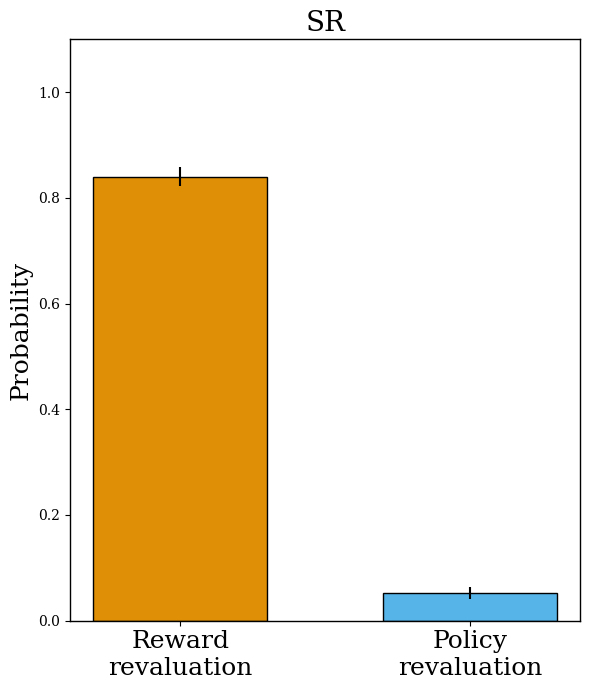

In [55]:
# save_path = save_dir + "NHB_SR.png"
save_path = None
means = [prob_reward_sr[0], prob_policy_sr[0]]
stds = [std_reward_sr, std_policy_sr]
xlabels = ['Reward\nrevaluation', 'Policy\nrevaluation']
colors = [1, 9]
ylabel = 'Probability'

# Call the function
create_bar_plot(means, colors, ylabel, xlabels, std=stds, save_path=save_path, title="SR")

## Complete Model

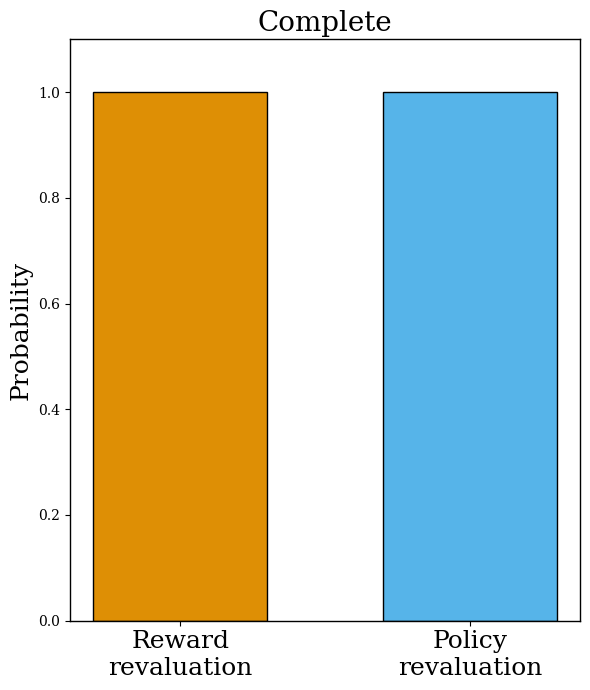

In [56]:
# save_path = save_dir + "NHB_Complete.png"
save_path = None
means = [prob_reward_complete[0], prob_policy_complete[0]]
stds = [std_reward_complete, std_policy_complete]
xlabels = ['Reward\nrevaluation', 'Policy\nrevaluation']
colors = [1, 9]
ylabel = 'Probability'

# Call the function
create_bar_plot(means, colors, ylabel, xlabels, std=stds, save_path=save_path, title="Complete")